# Generatively Pretrained Transformer (GPT)

## Load dataset

In [ ]:
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [3]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f'Length of dataset: {len(text)} characters')

Length of dataset: 1115394 characters


The first 400 characters are:

In [4]:
print(text[:400])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it 


## Vocabulary size

**Vocabulary size** is the number of unique characters.

**Note:** chars[0] is the new line character, '\n'. chars[1] is the space character, ' '.

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

print('Unique characters:', ''.join(chars))
print('Vocabulary size:', vocab_size)

Unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocabulary size: 65


## Tokenizer

**Tokenize** means convert the raw text as a string to some sequence of integers according to some vocabulary of possible elements.

We are building a character level language model so our tokenizer is going to simply translate individual characters into integers using a **lookup table**.

In [6]:
# mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

# Encoder: take a string, output a list of integers
encode = lambda s: [stoi[c] for c in s]

# Decoder: take a list of integers, output a string
decode = lambda l: ''.join([itos[i] for i in l])

print('Encoder output:', encode('hii there'))
print('Decoder output:', decode([46, 47, 47, 1, 58, 46, 43, 56, 43]))

Encoder output: [46, 47, 47, 1, 58, 46, 43, 56, 43]
Decoder output: hii there


Google uses [SentencePiece](https://github.com/google/sentencepiece?tab=readme-ov-file) tokenizer to also encode text into integers but in a different schema and using a different vocabulary. SentencePiece does not encode indivual characters or entire words but **sub-words units**. ChatGPT uses the OpenAI's [tiktoken](https://github.com/openai/tiktoken) library.

In [ ]:
# pip install tiktoken

In [7]:
import tiktoken

enc = tiktoken.get_encoding('gpt2')
print('Vocabulary size:', enc.n_vocab)

print('Encoder output:', enc.encode('hii there'))
print('Decoder output:', enc.decode([71, 4178, 612]))

Vocabulary size: 50257
Encoder output: [71, 4178, 612]
Decoder output: hii there


## Build dataset

We can now encode the entire text dataset and store it into a PyTorch tensor:

In [8]:
import torch
torch.manual_seed(1337)

data = torch.tensor(encode(text), dtype=torch.long)

print(data[:400]) # the earlier 400 characters will look like this to the GPT

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
        47, 59, 57,  1, 47, 57,  1, 41, 

Split up the data into train and validation sets:

In [9]:
n = int(0.9*len(data))
train_data = data[:n] # 90%
val_data = data[n:]   # 10%

## Time dimension

We cannot feed the entire training set into a transformer all at once because that would be computationally very expensive. Thus, when training the transformer we sample random little **chunks** out of the training set and train just a chunk at a time. The maximum length of those chunks is the **block size**.


In a chunk of nine characters there's actually eight individual examples packed into it (see below). That's because all of these characters follow each other so when we plug the chunk into a transformer, it simultaneously trains to make a prediction for every example.


We train on all the eight examples not just for efficiency but to make the transformer network used to seeing **contexts of size 1 up to block size**. That is useful later during inference because we can start the sampling generation with just 1 character. Then, the transformer knows how to predict the next characters all the way up to block size. After block size, we start truncating.

In [10]:
block_size = 8

print('Chunk:', train_data[:block_size+1].tolist())

x = train_data[:block_size]
y = train_data[1:block_size+1]

print('\nExamples:')
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f'{t+1}) When context is {context.tolist()} the target is {target}')

Chunk: [18, 47, 56, 57, 58, 1, 15, 47, 58]

Examples:
1) When context is [18] the target is 47
2) When context is [18, 47] the target is 56
3) When context is [18, 47, 56] the target is 57
4) When context is [18, 47, 56, 57] the target is 58
5) When context is [18, 47, 56, 57, 58] the target is 1
6) When context is [18, 47, 56, 57, 58, 1] the target is 15
7) When context is [18, 47, 56, 57, 58, 1, 15] the target is 47
8) When context is [18, 47, 56, 57, 58, 1, 15, 47] the target is 58


## CUDA

CUDA exploits the advantages of GPUs over CPUs by utilizing the **parallelism** offered by GPUs multiple cores, which allow to launch a high number of simultaneous threads.

We are going to add the ability to run on a GPU if it is available so everything is faster.

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Device:', device)

Device: cpu


## Batch dimension

Because GPUs are very good at **parallel processing** of data, we have **batches of multiple chunks** stacked up in a single tensor feeding into a transformer. Thus, multiple chunks can be processed at the same time but completely independently.

In [12]:
batch_size = 4 # number of chunks per bacth
block_size = 8 # chunks maximum context length

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

xb, yb = get_batch('train')

print('Inputs shape:', tuple(xb.shape))
print(xb)
print('\nTargets shape:', tuple(yb.shape))
print(yb)

Inputs shape: (4, 8)
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])

Targets shape: (4, 8)
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


# Bigram model

Although a Bigram model is a simple model, it will be a good start for the architecture of the GPT.

**Note:**
- B = Batch (batch_size)
- T = Time (block_size)
- C = Channels (vocab_size)

In [13]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B, T) tensor of integers

        # each token reads off the logits for the next token from a lookup table
        logits = self.token_embedding_table(idx) # (B, T, C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is the current context
        # in each iteration idx will grow:
        # (B, T), (B, T+1), (B, T+2), ..., (B, T+max_new_tokens)

        for _ in range(max_new_tokens):

            # get logits for current context (calling forward method)
            logits, _ = self(idx) # (B, T, C)

            # focus only on the last time-step because
            # those are the predictions for what comes next
            logits = logits[:, -1, :] # (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

In [14]:
model = BigramLanguageModel()
m = model.to(device)

## Evaluate the model

Instead of printing the bacth loss, the **estimate_loss()** function averages up the loss over multiple batches.

In [15]:
eval_iters = 200      # how many iterations used to calculate the loss
eval_interval = 10000 # every how many iterations calculate the loss

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval() # put the model in evaluation mode

    # calculate train loss and evaulation loss
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)

        for k in range(eval_iters):
            X, Y = get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()

        out[split] = losses.mean()

    model.train() # put the model back in train mode
    return out

## Train the model

In [16]:
learning_rate = 1e-3

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [17]:
batch_size = 32
max_iters = 40000

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"Step:{iter:6d} /{max_iters:6d}   Train loss: {losses['train']:.4f}   Val loss: {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # forward pass
    logits, loss = model(xb, yb)

    # backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    # update
    optimizer.step()

Step:     0 / 40000   Train loss: 4.6355   Val loss: 4.6491
Step: 10000 / 40000   Train loss: 2.4726   Val loss: 2.4923
Step: 20000 / 40000   Train loss: 2.4551   Val loss: 2.4864
Step: 30000 / 40000   Train loss: 2.4519   Val loss: 2.4940
Step: 39999 / 40000   Train loss: 2.4518   Val loss: 2.4949


## Generate from the model


**Note:** We start the generation with the tensor [[0]]. That is fine because 0 is the new line character. The generate method will generate more characters up to `max_new_tokens`.

**Note:** We are feeding the entire growing context (whatever is generated) into the model. However, because it is a bigram model we are only using the last previous character to predict the next charater.

In [18]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=300)[0].tolist()))


atecotofothe ofory.
S:
ICASI All n my their blil toce: ton?
Thigous m:
I tsours, gan thand fais ifif nowe? tipil
Thetour y an ounlirounch drit lat mavets spawind wous by fr. id,
Whad butheetlathithe u k I fand ng, witolm he outhatigu bery the n m ben,
Wh MESithay.



LI, pa it t icee wow bautimin th


# Attention

Attention is a **communication mechanism** that can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.

## Intro to attention




The tokens in each chunk are currently "not talking to each other" so we would like to **"couple them"**. In particular, we want to couple them so that the tokens **only communicate with the tokens before them** in the sequence.

The easiest way to achieve that is computing the **average** of the preceding tokens. Thus, the fourth token should take its channels and also the channels from the third step, the second step, and the first step, and average those up.

<br>

Consider the following chunk where every row would be a token and the columns the channels:

$$
\begin{bmatrix}
a_{11} & a_{12} & a_{13} & ... & a_{1C} \\
a_{21} & a_{22} & a_{23} & ... & a_{2C} \\
a_{31} & a_{32} & a_{33} & ... & a_{3C} \\
... & ... & ... & ... & ... \\
a_{T1} & a_{T2} & a_{T3} & ... & a_{TC}
\end{bmatrix}
$$

<br>

The tokens would communicate as follows:

$$
\begin{bmatrix}
a_{11} & a_{12} & a_{13} & ... & a_{1C} \\
\frac{a_{11} + a_{21}}{2} & \frac{a_{12} + a_{22}}{2} & \frac{a_{13} + a_{23}}{2} & ... & \frac{a_{1C} + a_{2C}}{2} \\
\frac{a_{11} + a_{21} + a_{31}}{3} & \frac{a_{12} + a_{22} + a_{32}}{3} & \frac{a_{13} + a_{23} + a_{33}}{3} & ... & \frac{a_{1C} + a_{2C} + a_{3C}}{3} \\
... & ... & ... & ... & ... \\
\frac{a_{11} + a_{21} + a_{31} + ... + a_{T1}}{T} & \frac{a_{12} + a_{22} + a_{32} + ... + a_{T2}}{T} & \frac{a_{13} + a_{23} + a_{33} + ... + a_{T3}}{T} & ... & \frac{a_{1C} + a_{2C} + a_{3C} + ... + a_{TC}}{T}
\end{bmatrix}
$$

<br>

We can implement that with two nested for loops:

In [19]:
B,T,C = 4,8,2 # batch, time, channels

x = torch.randn(B,T,C)
xbow = torch.zeros((B,T,C))

for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0) # (C)

Looking only at the first chunk of the batch:

In [20]:
print(x[0])
print(xbow[0])

tensor([[-0.8385,  0.7409],
        [ 0.5635, -0.6097],
        [ 1.8720,  0.0590],
        [ 0.1869, -0.2114],
        [ 1.5499,  0.2369],
        [-2.3956, -0.3363],
        [ 2.2205, -0.1176],
        [ 0.0070, -1.0434]])
tensor([[-0.8385,  0.7409],
        [-0.1375,  0.0656],
        [ 0.5323,  0.0634],
        [ 0.4460, -0.0053],
        [ 0.6668,  0.0431],
        [ 0.1564, -0.0201],
        [ 0.4512, -0.0340],
        [ 0.3957, -0.1602]])


We can be more efficient using matrix multiplication and a lower triangular matrix like the one below:
$$
\begin{bmatrix}
a_{11} & a_{12} & a_{13} & ... & a_{1C} \\
\frac{a_{11} + a_{21}}{2} & \frac{a_{12} + a_{22}}{2} & \frac{a_{13} + a_{23}}{2} & ... & \frac{a_{1C} + a_{2C}}{2} \\
\frac{a_{11} + a_{21} + a_{31}}{3} & \frac{a_{12} + a_{22} + a_{32}}{3} & \frac{a_{13} + a_{23} + a_{33}}{3} & ... & \frac{a_{1C} + a_{2C} + a_{3C}}{3} \\
... & ... & ... & ... & ... \\
\frac{a_{11} + a_{21} + a_{31} + ... + a_{T1}}{T} & \frac{a_{12} + a_{22} + a_{32} + ... + a_{T2}}{T} & \frac{a_{13} + a_{23} + a_{33} + ... + a_{T3}}{T} & ... & \frac{a_{1C} + a_{2C} + a_{3C} + ... + a_{TC}}{T}
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
\frac{1}{2} & \frac{1}{2} & 0 & 0 & 0 \\
\frac{1}{3} & \frac{1}{3} & \frac{1}{3} & 0 & 0 \\
\frac{1}{4} & \frac{1}{4} & \frac{1}{4} & \frac{1}{4} & 0 \\
\frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5}
\end{bmatrix}
\times
\begin{bmatrix}
a_{11} & a_{12} & a_{13} & ... & a_{1C} \\
a_{21} & a_{22} & a_{23} & ... & a_{2C} \\
a_{31} & a_{32} & a_{33} & ... & a_{3C} \\
... & ... & ... & ... & ... \\
a_{T1} & a_{T2} & a_{T3} & ... & a_{TC}
\end{bmatrix}
$$

<br>

**Note:** PyTorch will apply the matrix multiplication in all the batch elements (chunks) at the same time and independently.

In [21]:
wei = torch.tril(torch.ones(T, T))
wei /= wei.sum(1, keepdim=True) # (T, T)
xbow2 = wei @ x # (B, T, C) = (B, T, T) x (B, T, C)
torch.allclose(xbow, xbow2)

True

## Decoder attention

In ffact, the lower triangular matrix contains the weights for the weighted sum of the past elements. Those weights are **the interaction strength or affinity**, how much of each token from the past we want to aggregate and average up. We are going to modify the way we construct the lower triangular matrix. It will start being:

\begin{bmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0
\end{bmatrix}

<br>

Then, we will stop the communication with the future tokens by initializing those affinities to -inf:

\begin{bmatrix}
0 & -inf & -inf & -inf & -inf \\
0 & 0 & -inf & -inf & -inf \\
0 & 0 & 0 & -inf & -inf \\
0 & 0 & 0 & 0 & -inf \\
0 & 0 & 0 & 0 & 0
\end{bmatrix}

<br>

Finally, we will normalize with Softmax and get:

\begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
\frac{1}{2} & \frac{1}{2} & 0 & 0 & 0 \\
\frac{1}{3} & \frac{1}{3} & \frac{1}{3} & 0 & 0 \\
\frac{1}{4} & \frac{1}{4} & \frac{1}{4} & \frac{1}{4} & 0 \\
\frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5}
\end{bmatrix}

<br>

**Note:** We just created a **decoder attention block** because it has triangular masking so that nodes from the future never talk to the past. It is usually used in autoregressive settings, like language modeling. In an encoder attention block there is no masking, allowing all tokens to communicate with each other.

In [22]:
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

True

## Single-head self-attention

As we saw before, when we initialize the affinities between all the different tokens to 0, stop the communication with futurw tokens, and apply Softmax, we get the same weights in every row:

\begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
\frac{1}{2} & \frac{1}{2} & 0 & 0 & 0 \\
\frac{1}{3} & \frac{1}{3} & \frac{1}{3} & 0 & 0 \\
\frac{1}{4} & \frac{1}{4} & \frac{1}{4} & \frac{1}{4} & 0 \\
\frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5}
\end{bmatrix}

<br>

We want the weights in every row to change depending on the affinities between the tokens. Different tokens will find other tokens more or less interesting. Thus, we want to **gather data from the past in a data dependent way**.

**Self-attention** achieves that with a **query matrix** (what am I looking for) and a **key matrix** (what do I contain) for every token. The matrix multiplication of the querys with the transpose of the keys produces the affinities. Thus, the queries of a token dot product with the keys of all the other tokens. If the key and the query align, the affinity will be high for that iteraction.

$$
\begin{bmatrix}
a_{11} & a_{12} & a_{13} & ... & a_{1T} \\
a_{21} & a_{22} & a_{23} & ... & a_{2T} \\
a_{31} & a_{32} & a_{33} & ... & a_{3T} \\
... & ... & ... & ... & ... \\
a_{T1} & a_{T2} & a_{T3} & ... & a_{TT}
\end{bmatrix}
=
\begin{bmatrix}
q_{11} & q_{12} & q_{13} & ... & q_{1H} \\
q_{21} & q_{22} & q_{23} & ... & q_{2H} \\
q_{31} & q_{32} & q_{33} & ... & q_{3H} \\
... & ... & ... & ... & ... \\
q_{T1} & q_{T2} & q_{T3} & ... & q_{TH}
\end{bmatrix}
\times
\begin{bmatrix}
k_{11} & k_{12} & k_{13} & ... & k_{1T} \\
k_{21} & k_{22} & k_{23} & ... & k_{2T} \\
k_{31} & k_{32} & k_{33} & ... & k_{3T} \\
... & ... & ... & ... & ... \\
k_{H1} & k_{H2} & k_{H3} & ... & k_{HT}
\end{bmatrix}
$$

<br>

Then, we will stop the communication with the future tokens by initializing those affinities to -inf:

\begin{bmatrix}
a_{11} & -inf & -inf & -inf & -inf \\
a_{21} & a_{22} & -inf & -inf & -inf \\
a_{31} & a_{32} & a_{33} & -inf & -inf \\
a_{41} & a_{42} & a_{43} & a_{44} & -inf \\
a_{51} & a_{52} & a_{53} & a_{54} & a_{55}
\end{bmatrix}

<br>

Finally, we will normalize with Softmax and get:

\begin{bmatrix}
w_{11} & 0 & 0 & 0 & 0 \\
w_{21} & w_{22} & 0 & 0 & 0 \\
w_{31} & w_{32} & w_{33} & 0 & 0 \\
w_{41} & w_{42} & w_{43} & w_{44} & 0 \\
w_{51} & w_{52} & w_{53} & w_{54} & w_{55}
\end{bmatrix}

<br>

**Note:** To get `q` and `k` we are using the Linear modules `key` and `query`. They are just going to apply matrix multiplication of the input with some weights.

**Note:** When we do the agregation in a singe Head, we do not agregate the inputs directly. We instead agregate the values. To get `v` we use the Linear module `value` that just applies matrix multiplication of the input with some weights.

**Note:** We just created a **self-attention block** because the keys, the queries, and the values are all produced from the same source x. In a cross-attention block, the queries still get produced from x, but the keys and the values come from some other external source (e.g. an encoder module).

**Note:** We also used **scaled attention** because we divided `wey` by 1/sqrt(head_size). It is important because when `q` are `k` are unit variance, `wei` will be unit variance too and Softmax will stay diffuse and not saturate too much a value.

In [23]:
B,T,C = 4,8,32 # batch, time, channels

x = torch.randn(B,T,C)

# single Head performing self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

# compute keys and queries
k = key(x)   # (B, T, hs)
q = query(x) # (B, T, hs)

# compute attention scores ("affinities")
# for every bacth element, a square matrix contains the affinities
wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, T) = (B, T, hs) @ (B, hs, T)
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))  # (B, T, T)
wei = F.softmax(wei, dim=-1) # (B, T, T)

# perform the weighted aggregation of the values
v = value(x)     # (B, T, hs)
xbow4 = wei @ v  # (B, T, hs) = (B, T, T) @ (B, T, hs)

In [24]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5869, 0.4131, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3840, 0.2195, 0.3965, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2434, 0.1903, 0.2100, 0.3563, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1603, 0.3165, 0.1600, 0.1751, 0.1880, 0.0000, 0.0000, 0.0000],
        [0.1917, 0.1537, 0.2532, 0.1182, 0.1714, 0.1118, 0.0000, 0.0000],
        [0.1065, 0.2038, 0.1227, 0.0485, 0.2147, 0.1975, 0.1062, 0.0000],
        [0.1073, 0.1170, 0.1459, 0.0803, 0.0903, 0.2218, 0.1404, 0.0971]],
       grad_fn=<SelectBackward0>)

## Head module (Fix)

**Note:** `trill` is not a parameter of the module so it is a **buffer** according to PyTorch naming conventions.

In [25]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()

        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):

        B,T,C = x.shape

        # compute keys and queries
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)

        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, T) = (B, T, hs) @ (B, hs, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)

        # perform the weighted aggregation of the values
        v = self.value(x) # (B, T, hs)
        out = wei @ v     # (B, T, hs) = (B, T, T) @ (B, T, hs)

        return out

**Note:** In attention, there is **no notion of space**, it simply acts over a set of vectors. That is why we need to positionally encode the tokens.

In [26]:
n_embd = 32 # number of embedding dimensions

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_head = Head(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):

        B, T = idx.shape

        # identity and positional embeddings from lookup tables
        tok_emb = self.token_embedding_table(idx) # (B,T,n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,n_embd)
        x = tok_emb + pos_emb # (B,T,n_embd)

        # apply one head of self-attention
        x = self.sa_head(x) # (B,T,n_embd)

        # logits from language modeling head
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is the current context
        # in each iteration idx will grow:
        # (B, T), (B, T+1), (B, T+2), ..., (B, T+max_new_tokens)

        for _ in range(max_new_tokens):

            # crop the context to the last block_size tokens
            idx_cond = idx[:, -block_size:]

            # get logits for current context (calling forward method)
            logits, _ = self(idx_cond) # (B, T, C)

            # focus only on the last time-step because
            # those are the predictions for what comes next
            logits = logits[:, -1, :] # (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

Using single-head self-attention the validation loss went down from 2.45 to 2.35.

## Multi-head self-attention

Multi-head attention is just applying **multiple attentions in parallel** and concatenating the results. It usually helps to have multiple communication channels of heads with smaller head size than just a single communication channel of one head.

In [27]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()

        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1)

In [28]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        # 4 heads of 8-dimensional self-attention
        self.sa_heads = MultiHeadAttention(4, n_embd//4)

        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):

        B, T = idx.shape

        # identity and positional embeddings from lookup tables
        tok_emb = self.token_embedding_table(idx) # (B,T,n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,n_embd)
        x = tok_emb + pos_emb # (B,T,n_embd)

        # apply multi-head self-attention
        x = self.sa_heads(x) # (B,T,n_embd)

        # logits from language modeling head
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is the current context
        # in each iteration idx will grow:
        # (B, T), (B, T+1), (B, T+2), ..., (B, T+max_new_tokens)

        for _ in range(max_new_tokens):

            # crop the context to the last block_size tokens
            idx_cond = idx[:, -block_size:]

            # get logits for current context (calling forward method)
            logits, _ = self(idx_cond) # (B, T, C)

            # focus only on the last time-step because
            # those are the predictions for what comes next
            logits = logits[:, -1, :] # (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

Using multi-head self-attention the validation loss went down from 2.35 to 2.2.

## Feedforward layer (fix)

The multi-headed self-attention did the communication, so the tokens looked at each other, but they didn't really think on what they found from the other tokens.

The feedforward layer acts on a per token level so once they have gathered all the data they **think on that data** individually.

In [29]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [30]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_heads = MultiHeadAttention(4, n_embd//4)
        self.ffwd = FeedFoward(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):

        B, T = idx.shape

        # identity and positional embeddings from lookup tables
        tok_emb = self.token_embedding_table(idx) # (B,T,n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,n_embd)
        x = tok_emb + pos_emb # (B,T,n_embd)

        # apply multi-head self-attention
        x = self.sa_heads(x) # (B,T,n_embd)

        # apply the FeedFoward layer
        x = self.ffwd(x) # (B,T,n_embd)

        # logits from language modeling head
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is the current context
        # in each iteration idx will grow:
        # (B, T), (B, T+1), (B, T+2), ..., (B, T+max_new_tokens)

        for _ in range(max_new_tokens):

            # crop the context to the last block_size tokens
            idx_cond = idx[:, -block_size:]

            # get logits for current context (calling forward method)
            logits, _ = self(idx_cond) # (B, T, C)

            # focus only on the last time-step because
            # those are the predictions for what comes next
            logits = logits[:, -1, :] # (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

Using a single feeforward layer the validation loss went down from 2.2 to 2.16.

## Block

A block **intersperses communication** (done using multi-headed self-attention) **and computation** (done using the feedforward network on all the tokens)

In [31]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()

        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)

    def forward(self, x):

        # communication
        x = self.sa(x)

        # computation
        x = self.ffwd(x)

        return x

In [32]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):

        B, T = idx.shape

        # identity and positional embeddings from lookup tables
        tok_emb = self.token_embedding_table(idx) # (B,T,n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,n_embd)
        x = tok_emb + pos_emb # (B,T,n_embd)

        # apply blocks
        x = self.blocks(x) # (B,T,n_embd)

        # logits from language modeling head
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is the current context
        # in each iteration idx will grow:
        # (B, T), (B, T+1), (B, T+2), ..., (B, T+max_new_tokens)

        for _ in range(max_new_tokens):

            # crop the context to the last block_size tokens
            idx_cond = idx[:, -block_size:]

            # get logits for current context (calling forward method)
            logits, _ = self(idx_cond) # (B, T, C)

            # focus only on the last time-step because
            # those are the predictions for what comes next
            logits = logits[:, -1, :] # (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

Using 3 blocks the validation loss went down from 2.16 to 2.1.

## Residual connections

We are starting to get a deep neural net that suffers from optimization issues.

The residual connections or skip connections were introduced in the paper [He et al. (2015). *Deep Residual Learning for Image Recognition*](https://arxiv.org/abs/1512.03385) and help with the optimization. The idea is you transform the data but then you have a skip connection with addition from the previous features:

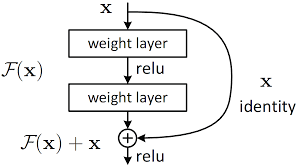

Another way to visualize it is that you have a residual pathway and you have some residual blocks (that fork off, perform some computation, and project back via addition). During the optimization the residual blocks start to contribute over time. The advantage is that at least at the initialization, during backpropagation the gradient just flows unimpeded from the supervision to the input.

[IMAGE]

**Note:** The projection is just a linear transformation (*y=x·w+b*) of the output when going back to the residual pathway.

In [39]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()

        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)

    def forward(self, x):

        # multi-headed self-attention
        out = torch.cat([h(x) for h in self.heads], dim=-1)

        # projection
        out = self.proj(out)

        return out

In [40]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), # growing inner-layer
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # projection layer
        )

    def forward(self, x):
        return self.net(x)

In [41]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()

        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)

    def forward(self, x):

        # communication with residual connections
        x = x + self.sa(x)

        # computation with residual connections
        x = x + self.ffwd(x)

        return x

Using residual connections the validation loss went down from 2.1 to 1.94.

## Layer Norm

Layer Norm also helps with the optimization of deep neural networks and is described in the paper [Ba et al. (2016). *Layer Normalization*](https://arxiv.org/abs/1607.06450). Remember that Batch Normalization made sure that across the batch dimension any individual neuron had unit gaussian distribution (0 mean and 1 standard deviation output).

Layer Normalization is identical to Batch Normalization but normalizes across the rows instead of the columns, does not need the running mean and the running variance buffers, and there is no distinction beteween train and test time.

In [49]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    xmean = x.mean(1, keepdim=True)
    xvar = x.var(1, keepdim=True)
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In the paper [Vaswani et al. (2017). *Attention is All You Need paper*](https://arxiv.org/abs/1706.03762) the "Add & Norm" is applied after the transformation. Nowadays, it is more common to apply the layer norm before the tranformation (this is called **pre-norm formulation**).

**Note:** The layer normalization acts on a per token level and normalizes the features making them unit Gaussian at initialization.

In [50]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()

        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):

        # communication with residual connections and layer norm
        x = x + self.sa(self.ln1(x))

        # computation with residual connections and layer norm
        x = x + self.ffwd(self.ln2(x))

        return x

It is also common to add a layer norm at the end of the transformer and right before the final linear layer that decodes into vocabulary:

In [54]:
n_layer = 3 # number of blocks
n_head = 4  # number of heads

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):

        B, T = idx.shape

        # identity and positional embeddings from lookup tables
        tok_emb = self.token_embedding_table(idx) # (B,T,n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,n_embd)
        x = tok_emb + pos_emb # (B,T,n_embd)

        # apply blocks
        x = self.blocks(x) # (B,T,n_embd)

        # final layer norm
        x = self.ln_f(x) # (B,T,n_embd)

        # logits from language modeling head
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is the current context
        # in each iteration idx will grow:
        # (B, T), (B, T+1), (B, T+2), ..., (B, T+max_new_tokens)

        for _ in range(max_new_tokens):

            # crop the context to the last block_size tokens
            idx_cond = idx[:, -block_size:]

            # get logits for current context (calling forward method)
            logits, _ = self(idx_cond) # (B, T, C)

            # focus only on the last time-step because
            # those are the predictions for what comes next
            logits = logits[:, -1, :] # (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

Using layer normalization the validation loss went down from 1.94 to 1.94.

## Dropout

Dropout is a regularization technique described in the paper [Srivastava et al. (2014). *Dropout: A Simple Way to Prevent Neural Networks from Overfitting*](https://jmlr.org/papers/v15/srivastava14a.html)
and it consists on randomly shut off some subset of neurons every forward backward pass and train without them.

IMAGE

Dropout is added when we calculate the affinities after Softmax so we randomly prevent some of the nodes from communicating.

In [ ]:
dropout = 0.2

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()

        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        B,T,C = x.shape

        # compute keys and queries
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)

        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, T) = (B, T, hs) @ (B, hs, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)

        # perform the weighted aggregation of the values
        v = self.value(x) # (B, T, hs)
        out = wei @ v     # (B, T, hs) = (B, T, T) @ (B, T, hs)

        return out

Dropout is also added right after the projection back to the residual pathway.

In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()

        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        # multi-headed self-attention
        out = torch.cat([h(x) for h in self.heads], dim=-1)

        # projection
        out = self.proj(out)

        return out

In [ ]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), # growing inner-layer
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # projection layer
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

## Scaling up the model

In [ ]:
# hyperparameters
batch_size = 64  # number of chunks per bacth
block_size = 256 # chunks maximum context length
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200      # how many iterations used to calculate the loss
eval_interval = 500   # every how many iterations calculate the loss
learning_rate = 3e-4
max_iters = 5000
n_embd = 384 # number of embedding dimensions
n_layer = 6 # number of blocks
n_head = 6  # number of heads
dropout = 0.2

In [55]:
# intialize the model
model = GPTLanguageModel()
m = model.to(device)

In [56]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [57]:
# train the model
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"Step:{iter:5d} /{max_iters:5d}   Train loss: {losses['train']:.4f}   Val loss: {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # forward pass
    logits, loss = model(xb, yb)

    # backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    # update
    optimizer.step()

Step:     0 / 40000   Train loss: 4.3091   Val loss: 4.3191
Step: 10000 / 40000   Train loss: 1.8911   Val loss: 2.0113
Step: 20000 / 40000   Train loss: 1.8433   Val loss: 1.9633
Step: 30000 / 40000   Train loss: 1.8120   Val loss: 1.9491
Step: 39999 / 40000   Train loss: 1.7939   Val loss: 1.9615


In [48]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=300)[0].tolist()))



NORFOLK:
Hell mad; be look'd can this prepard's,
Lord:
It slain; but this Edward as of have flell night?

QUE:
She fepon.

KING XI:
If that cousin?

FRIZEL:
God's god,
My slord.

BULINGANIA:
What, mle own but speak your his foor spatch'd free accenged Heaven be would in that gefected,
What is despe
